In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import scipy.stats

In [2]:
figure_path = './figures'
os.makedirs(figure_path, exist_ok=True)

In [3]:
parameters = {
    'A': {
        'incidence': 0.25,
        'beta_counts': 10,
        'color': 'b'
    },
    'B': {
        'incidence': 0.15,
        'beta_counts': 25,
        'color': 'g'
    }
}

In [4]:
# Compute beta parameters
for key, value in parameters.items():
    parameters[key]['alpha'] = value['incidence'] * value['beta_counts']
    parameters[key]['beta'] = (1-value['incidence']) * value['beta_counts']
    
    # Compute the unconditional distribution
    parameters[key]['x'] = np.linspace(
        0.0001,
        0.9999,
        10000
    )
    parameters[key]['pdf'] = scipy.stats.beta.pdf(parameters[key]['x'], parameters[key]['alpha'], parameters[key]['beta'])
    
    # Compute the conditional distributions
    parameters[key]['pdf_1'] = parameters[key]['x']*parameters[key]['pdf'] / parameters[key]['incidence']
    parameters[key]['pdf_0'] = (1-parameters[key]['x'])*parameters[key]['pdf'] / (1-parameters[key]['incidence'])
    parameters[key]['calibration_curve'] = (parameters[key]['pdf_1']*parameters[key]['incidence']) / parameters[key]['pdf']
    
    

In [5]:
# New group A-new, as a transformation of A to the conditional distributions of B
key = 'A-new'
source_group = 'A'
target_group = 'B'

parameters[key] = {'incidence': parameters[source_group]['incidence'], 'color': 'orange'}

parameters[key]['x'] = np.linspace(
    0.0001,
    0.9999,
    10000
)

# Compute the conditional distributions
parameters[key]['pdf_1'] = parameters[target_group]['pdf_1']
parameters[key]['pdf_0'] = parameters[target_group]['pdf_0']
parameters[key]['pdf'] = (parameters[key]['pdf_1']*parameters[key]['incidence']) + (parameters[key]['pdf_0']*(1-parameters[key]['incidence']))
parameters[key]['calibration_curve'] = (parameters[key]['pdf_1']*parameters[key]['incidence']) / parameters[key]['pdf']

# New group B-new, as a transformation of B to the conditional distributions of A
key = 'B-new'
source_group = 'B'
target_group = 'A'

parameters[key] = {'incidence': parameters[source_group]['incidence'], 'color': 'g'}

parameters[key]['x'] = np.linspace(
    0.0001,
    0.9999,
    10000
)

# Compute the conditional distributions
parameters[key]['pdf_1'] = parameters[target_group]['pdf_1']
parameters[key]['pdf_0'] = parameters[target_group]['pdf_0']
parameters[key]['pdf'] = (parameters[key]['pdf_1']*parameters[key]['incidence']) + (parameters[key]['pdf_0']*(1-parameters[key]['incidence']))
parameters[key]['calibration_curve'] = (parameters[key]['pdf_1']*parameters[key]['incidence']) / parameters[key]['pdf']


In [6]:
def plot_distributions(
    parameters,
    plot_x='x', 
    plot_y='pdf', 
    ax=plt.gca(), 
    groups = None, 
    title='', 
    legend=False, 
    apply_fill=True,
    fill_min=None, 
    fill_max=None,
    threshold = None,
    calibration_curve=False
):
    
    if groups is None:
        groups = parameters.keys()
        
    for key in groups:
        
        ax.plot(parameters[key][plot_x], parameters[key][plot_y], color=parameters[key]['color'])
        
        if apply_fill:
            if fill_min is None:
                fill_min = parameters[key][plot_x].min()
            if fill_max is None:
                fill_max = parameters[key][plot_x].max()

            fill_mask = (parameters[key][plot_x] >= fill_min) & (parameters[key][plot_x] <= fill_max)
            ax.fill_between(
                parameters[key][plot_x][fill_mask], 0, parameters[key][plot_y][fill_mask], color=parameters[key]['color'], alpha=0.5, label=f'Group {key}'
            )
        if threshold is not None:
            ax.axvline(threshold, color='k', linestyle='--')
            
        if calibration_curve:
            # Plot a dashed x=y for comparison with perfect calibration
            ax.plot(parameters[key][plot_x], parameters[key][plot_x], linestyle='--', color='gray')

    ax.set_xlim([0, 1])
    ax.set_title(title, fontsize=14)

In [7]:
def get_performance_metrics(parameters, threshold):
    result = {key: {} for key in parameters.keys()}
    for key, value in parameters.items():
        the_x = parameters['A']['x']
        threshold_mask = the_x >= threshold
        threshold_neg_mask = the_x < threshold
        
        result[key]['TPR'] = scipy.integrate.cumulative_trapezoid(
            y=value['pdf_1'][threshold_mask], 
            x=the_x[threshold_mask]
        )[-1]

        result[key]['FNR'] = scipy.integrate.cumulative_trapezoid(
            y=value['pdf_1'][threshold_neg_mask], 
            x=the_x[threshold_neg_mask]
        )[-1]
            
        result[key]['FPR'] = scipy.integrate.cumulative_trapezoid(
            y=value['pdf_0'][threshold_mask], 
            x=the_x[threshold_mask]
        )[-1]
        
        result[key]['TNR'] = scipy.integrate.cumulative_trapezoid(
            y=value['pdf_0'][threshold_neg_mask], 
            x=the_x[threshold_neg_mask]
        )[-1]
        
        try:
            result[key]['PPV'] = scipy.stats.beta.expect(
                scipy.interpolate.interp1d(value['x'], value['calibration_curve']),
                args=(value['alpha'], value['beta']), 
                lb=threshold, 
                conditional=True
            )
        except:
            # Compute with numerical integration
            result[key]['PPV'] = scipy.integrate.cumulative_trapezoid(
                y=value['calibration_curve'][threshold_mask]*value['pdf'][threshold_mask],
                x=the_x[threshold_mask]
            )[-1] / scipy.integrate.cumulative_trapezoid(
                y=value['pdf'][threshold_mask],
                x=the_x[threshold_mask]
            )[-1]
            
    return result
    
threshold=0.2
performance_metrics = get_performance_metrics(parameters, threshold)
pd.DataFrame(performance_metrics)

,A,B,A-new,B-new
TPR,0.794362,0.370880,0.370880,0.794362
FNR,0.205394,0.628650,0.628650,0.205394
FPR,0.533235,0.193845,0.193845,0.533235
TNR,0.466439,0.805823,0.805823,0.466439
PPV,0.331750,0.252347,0.389410,0.208165


In [8]:
len(parameters['A']['x'])

10000

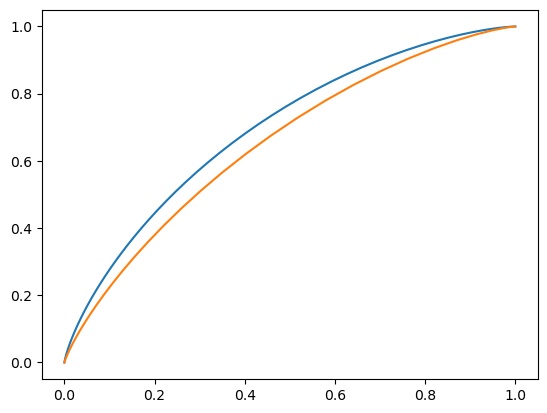

In [9]:
thresholds = parameters[key]['x'] = np.linspace(
    0.001,
    0.999,
    100
)

metrics = {the_threshold: get_performance_metrics(parameters, the_threshold) for the_threshold in thresholds}
metrics_df=pd.concat({key: pd.DataFrame(value) for key, value in metrics.items()})
metrics_df = metrics_df.rename_axis(['threshold', 'metric']).reset_index()
for key in parameters.keys():
    parameters[key]['FPR'] = metrics_df.query('metric == "FPR"')[key].values
    parameters[key]['TPR'] = metrics_df.query('metric == "TPR"')[key].values
    
plt.plot(metrics_df.query('metric == "FPR"')['A'], metrics_df.query('metric == "TPR"')['A'])
plt.plot(metrics_df.query('metric == "FPR"')['B'], metrics_df.query('metric == "TPR"')['B'])
plt.show()

In [10]:
figsize=(8,1)
wspace=0.5

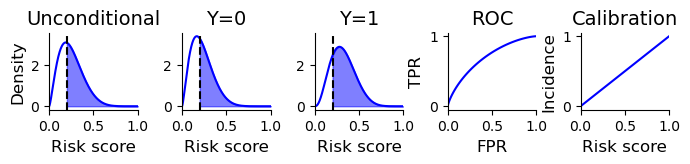

In [11]:
# Plot for group A

plt.close()
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=figsize, sharey=False, sharex=True)
axes = [ax1, ax2, ax3, ax4, ax5]
    
plot_distributions(parameters, plot_y='pdf', ax=ax1, title='Unconditional', groups='A', fill_min=threshold, threshold=threshold)
plot_distributions(parameters, plot_y='pdf_0', ax=ax2, title='Y=0', groups='A', fill_min=threshold, threshold=threshold)
plot_distributions(parameters, plot_y='pdf_1', ax=ax3, title='Y=1', groups='A', fill_min=threshold, threshold=threshold)
plot_distributions(parameters, plot_x='FPR', plot_y='TPR', ax=ax4, title='ROC', groups='A', apply_fill=False)

plot_distributions(parameters, 
    plot_y='calibration_curve', 
    ax=ax5, 
    title='Calibration', 
    groups='A', 
    apply_fill=False
)

fig.subplots_adjust(wspace=wspace)
ax1.set_ylabel('Density', fontsize=12)
ax4.set_ylabel('TPR', fontsize=12)
ax4.set_xlabel('FPR', fontsize=12)
ax5.set_ylabel('Incidence', fontsize=12)

for ax in [ax1, ax2, ax3, ax5]:
    ax.set_xlabel('Risk score', fontsize=12)

ax1.sharey(ax2)
ax3.sharey(ax2)

sns.despine()
plt.show()
fig.savefig(os.path.join(figure_path, 'one_group_distributions.png'), dpi=300, bbox_inches="tight")

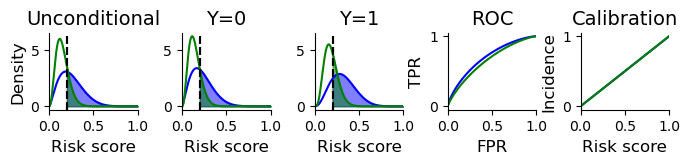

In [12]:
# Plot A and B

plt.close()
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=figsize, sharey=False, sharex=True)
axes = [ax1, ax2, ax3, ax4, ax5]
    
plot_distributions(parameters, plot_y='pdf', ax=ax1, title='Unconditional', groups=['A','B'], fill_min=threshold, threshold=threshold)
plot_distributions(parameters, plot_y='pdf_0', ax=ax2, title='Y=0', groups=['A','B'], fill_min=threshold, threshold=threshold)
plot_distributions(parameters, plot_y='pdf_1', ax=ax3, title='Y=1', groups=['A','B'], fill_min=threshold, threshold=threshold)
plot_distributions(parameters, plot_x='FPR', plot_y='TPR', ax=ax4, title='ROC', groups=['A','B'], apply_fill=False)

plot_distributions(parameters, 
    plot_y='calibration_curve', 
    ax=ax5, 
    title='Calibration', 
    groups=['A','B'], 
    apply_fill=False
)

fig.subplots_adjust(wspace=wspace)
ax1.set_ylabel('Density', fontsize=12)
ax4.set_ylabel('TPR', fontsize=12)
ax4.set_xlabel('FPR', fontsize=12)
ax5.set_ylabel('Incidence', fontsize=12)

for ax in [ax1, ax2, ax3, ax5]:
    ax.set_xlabel('Risk score', fontsize=12)

ax1.sharey(ax2)
ax3.sharey(ax2)

sns.despine()
plt.show()
fig.savefig(os.path.join(figure_path, 'two_group_distributions.png'), dpi=300, bbox_inches="tight")

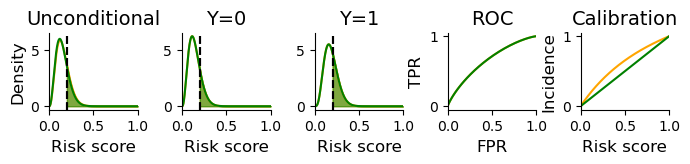

In [13]:
# Plot A-new and B

plt.close()
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=figsize, sharey=False, sharex=True)
axes = [ax1, ax2, ax3, ax4, ax5]
    
plot_distributions(parameters, plot_y='pdf', ax=ax1, title='Unconditional', groups=['A-new','B'], fill_min=threshold, threshold=threshold)
plot_distributions(parameters, plot_y='pdf_0', ax=ax2, title='Y=0', groups=['A-new','B'], fill_min=threshold, threshold=threshold)
plot_distributions(parameters, plot_y='pdf_1', ax=ax3, title='Y=1', groups=['A-new','B'], fill_min=threshold, threshold=threshold)
plot_distributions(parameters, plot_x='FPR', plot_y='TPR', ax=ax4, title='ROC', groups=['A-new','B'], apply_fill=False)

plot_distributions(parameters, 
    plot_y='calibration_curve', 
    ax=ax5, 
    title='Calibration', 
    groups=['A-new','B'], 
    apply_fill=False
)

fig.subplots_adjust(wspace=wspace)
ax1.set_ylabel('Density', fontsize=12)
ax4.set_ylabel('TPR', fontsize=12)
ax4.set_xlabel('FPR', fontsize=12)
ax5.set_ylabel('Incidence', fontsize=12)

for ax in [ax1, ax2, ax3, ax5]:
    ax.set_xlabel('Risk score', fontsize=12)

ax1.sharey(ax2)
ax3.sharey(ax2)

sns.despine()
plt.show()
fig.savefig(os.path.join(figure_path, 'two_group_distributions_miscalibrated.png'), dpi=300, bbox_inches="tight")

### Utility
Assume a utility function, show that it entails an optimal threshold conditioned on the risk

In [14]:
# Utility functions
u_tp = 0.8
u_fn = 0
u_fp = 0
u_tn = 0.2

u_pos = u_tp - u_fn
u_neg = u_tn - u_fp
optimal_threshold = u_neg / (u_pos+u_neg)

In [15]:
# The values for the risk score
risk_values = parameters['A']['x']

# Conditional utility of treating vs not-treating
u_treat = risk_values*u_tp + (1-risk_values)*u_fp
u_no_treat = risk_values*u_fn + (1-risk_values)*u_tn
conditional_utility = u_treat - u_no_treat

# Miscalibrated model
u_treat_miscalibrated = parameters['A-new']['calibration_curve']*u_tp + (1-parameters['A-new']['calibration_curve'])*u_fp
u_no_treat_miscalibrated = parameters['A-new']['calibration_curve']*u_fn + (1-parameters['A-new']['calibration_curve'])*u_tn
conditional_utility_miscalibrated = u_treat_miscalibrated - u_no_treat_miscalibrated
optimal_threshold_miscalibrated = risk_values[np.abs(conditional_utility_miscalibrated).argmin()]
print(f'Optimal miscalibrated threshold: {optimal_threshold_miscalibrated}')

Optimal miscalibrated threshold: 0.11688831883188319


In [16]:
# Cumulative utility
cumulative_utility = np.zeros_like(risk_values)
cumulative_utility_miscalibrated = np.zeros_like(risk_values)
cumulative_utility_group_b = np.zeros_like(risk_values)

for i, t in enumerate(risk_values):
    threshold_mask = risk_values >= t
    threshold_neg_mask = risk_values < t
    # Calibrated model
    try:
        cumulative_utility_rhs = scipy.integrate.cumulative_trapezoid(
            y=u_treat[threshold_mask]*parameters['A']['pdf'][threshold_mask],
            x=risk_values[threshold_mask]
        )[-1]
    except:
        cumulative_utility_rhs = 0.0
    try:
        cumulative_utility_lhs = scipy.integrate.cumulative_trapezoid(
            y=u_no_treat[threshold_neg_mask]*parameters['A']['pdf'][threshold_neg_mask],
            x=risk_values[threshold_neg_mask]
        )[-1]
    except:
        cumulative_utility_lhs = 0.0
    
    cumulative_utility[i] = cumulative_utility_rhs + cumulative_utility_lhs
    
    # Miscalibrated model
    try:
        cumulative_utility_rhs_miscalibrated = scipy.integrate.cumulative_trapezoid(
            y=u_treat_miscalibrated[threshold_mask]*parameters['A-new']['pdf'][threshold_mask],
            x=risk_values[threshold_mask]
        )[-1]
    except:
        cumulative_utility_rhs_miscalibrated = 0.0
    try:
        cumulative_utility_lhs_miscalibrated = scipy.integrate.cumulative_trapezoid(
            y=u_no_treat_miscalibrated[threshold_neg_mask]*parameters['A-new']['pdf'][threshold_neg_mask],
            x=risk_values[threshold_neg_mask]
        )[-1]
    except:
        cumulative_utility_lhs_miscalibrated = 0.0
    
    cumulative_utility_miscalibrated[i] = cumulative_utility_rhs_miscalibrated + cumulative_utility_lhs_miscalibrated
    
    # Calibrated model
    try:
        cumulative_utility_rhs = scipy.integrate.cumulative_trapezoid(
            y=u_treat[threshold_mask]*parameters['B']['pdf'][threshold_mask],
            x=risk_values[threshold_mask]
        )[-1]
    except:
        cumulative_utility_rhs = 0.0
    try:
        cumulative_utility_lhs = scipy.integrate.cumulative_trapezoid(
            y=u_no_treat[threshold_neg_mask]*parameters['B']['pdf'][threshold_neg_mask],
            x=risk_values[threshold_neg_mask]
        )[-1]
    except:
        cumulative_utility_lhs = 0.0
    
    cumulative_utility_group_b[i] = cumulative_utility_rhs + cumulative_utility_lhs

In [17]:
# Compute the implicit threshold
implicit_threshold=parameters['A-new']['calibration_curve'][np.abs(parameters['A-new']['x'] - optimal_threshold).argmin()]
print(f'Implicit threshold: {implicit_threshold}')

Implicit threshold: 0.3207274935739585


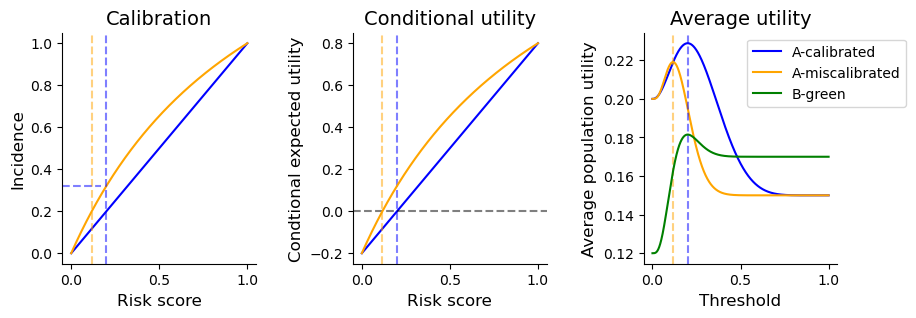

In [23]:
# Make plot
plt.close()
fig, (ax3, ax1, ax2) = plt.subplots(1, 3, figsize=(10,3), sharex=True)
fig.subplots_adjust(wspace=wspace)

# ax = plt.gca()
ax1.plot(risk_values, conditional_utility, color='b', label='A-calibrated')
ax1.axvline(optimal_threshold, linestyle='--', color='b', alpha=0.5)
ax1.axhline(color = 'k', linestyle='--', alpha=0.5)
ax1.plot(risk_values, conditional_utility_miscalibrated, color='orange', label='A-miscalibrated')
# ax1.plot(risk_values, conditional_utility, color='g', label='B-green', alpha=0.5)
ax1.axvline(optimal_threshold_miscalibrated, color='orange', linestyle='--', alpha=0.5)

# sns.despine()
ax1.set_xlabel('Risk score', fontsize=12)
ax1.set_ylabel('Condtional expected utility',fontsize=12)
ax1.set_title('Conditional utility', fontsize=14)

ax2.plot(risk_values, cumulative_utility, color='b', label='A-calibrated')
ax2.plot(risk_values, cumulative_utility_miscalibrated, color='orange', label='A-miscalibrated')
ax2.axvline(optimal_threshold, linestyle='--', color='b', alpha=0.5)
ax2.axvline(optimal_threshold_miscalibrated, linestyle='--', color='orange', alpha=0.5)
ax2.plot(risk_values, cumulative_utility_group_b, color='green', label='B-green')
ax2.set_ylabel('Average population utility', fontsize=12)
ax2.set_xlabel('Threshold',fontsize=12)
ax2.set_title('Average utility', fontsize=14)

ax3.plot(parameters['A']['x'], parameters['A']['calibration_curve'], color = parameters['A']['color'], label='A-calibrated')
# ax3.plot(parameters['B']['x'], parameters['B']['calibration_curve'], color = parameters['B']['color'], label='B-green', alpha=0.5)
ax3.plot(parameters['A-new']['x'], parameters['A-new']['calibration_curve'], color = parameters['A-new']['color'], label='A-miscalibrated')
ax3.axvline(optimal_threshold, linestyle='--', color='b', alpha=0.5)
ax3.axvline(optimal_threshold_miscalibrated, linestyle='--', color=parameters['A-new']['color'], alpha=0.5)
ax3.axhline(implicit_threshold, xmax=optimal_threshold, linestyle='--', color=parameters['A']['color'], alpha=0.5)
ax3.set_xlabel('Risk score', fontsize=12)
ax3.set_ylabel('Incidence', fontsize=12)
ax3.set_title('Calibration', fontsize=14)

plt.legend(bbox_to_anchor=(0.5, 1))
sns.despine()
plt.show()
fig.savefig(os.path.join(figure_path, 'utility_threshold.png'), dpi=300, bbox_inches="tight")